In [80]:
import os
import logging
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import uniform
from rich.console import Console
from rich.table import Table
from rich.text import Text

# Configurazione di TensorFlow per ridurre l'output non necessario
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Questo rimuove i log informativi e warnings di TensorFlow
tf.get_logger().setLevel(logging.ERROR)

# Ignora i warning
warnings.filterwarnings("ignore")


In [81]:
console = Console()

def printSuccess(message):
    """
    Prints the given message in bright green.
    
    Parameters:
    - message (str): The message to print
    """
    success_text = Text(message, style="bold bright_green")
    console.print(success_text)

def printError(message):
    """
    Prints the given message in bright red.
    
    Parameters:
    - message (str): The message to print
    """
    error_text = Text(message, style="bold bright_red")
    console.print(error_text)

def create_rich_table(title, columns, rows):
    """
    Crea e stampa una tabella formattata con Rich.

    Parameters:
    - title (str): Il titolo della tabella.
    - columns (list of dict): Lista di dizionari, ognuno contenente il nome della colonna e opzioni come 'justify' e 'style'.
      Esempio: [{'header': 'Col1', 'justify': 'right', 'style': 'cyan'}, {...}]
    - rows (list of list): Lista di righe, ognuna contenente i valori delle colonne in ordine.
      Esempio: [['Val1', 'Val2', ...], ['ValA', 'ValB', ...]]
    """
    table = Table(title=title)
    
    # Aggiungi colonne alla tabella
    for col in columns:
        table.add_column(col['header'], justify=col.get('justify', 'center'), style=col.get('style', 'bright_white'))
    
    # Aggiungi righe alla tabella
    for row in rows:
        table.add_row(*row)
    
    # Stampa la tabella
    console.print(table)

# Funzione per stampare i risultati in una tabella con Rich
def print_evaluation_table(model_name, test_class_report, test_accuracy):
    console = Console()
    table = Table(title="Model Evaluation Results for " + model_name)

    # Aggiunta delle colonne
    table.add_column("Metric", style="bright_cyan", no_wrap=True)
    table.add_column("Result", justify="center", style="bright_green")

    # Aggiunta dei risultati
    table.add_row("Accuracy", f"{test_accuracy:.4f}")
    table.add_row("Precision (wgtd_avg)", f"{test_class_report['weighted avg']['precision']:.4f}")
    table.add_row("Recall (wgtd_avg)",  f"{test_class_report['weighted avg']['recall']:.4f}")
    table.add_row("F1-Score (wgtd_avg)", f"{test_class_report['weighted avg']['f1-score']:.4f}")

    # Stampa della tabella
    console.print(table)

# Stampa dei migliori iperparametri in una tabella con Rich
def print_best_params_table(model_name, best_params):
    console = Console()
    table = Table(title="Best Hyperparameters for " + model_name)

    table.add_column("Hyperparameter", style="bright_cyan", no_wrap=True)
    table.add_column("Value", justify="center", style="bright_magenta")

    for param, value in best_params.items():
        table.add_row(param, str(value))

    console.print(table)

In [82]:
# Dizionario globale per memorizzare i risultati dei vari modelli
global_model_results = {}

def save_model_results(model_name, test_class_report, test_accuracy):
    """
    Salva i risultati del modello nel dizionario globale.
    
    Args:
        model_name (str): Nome del modello (es. 'KNN', 'Random Forest', 'Logistic Regression').
        test_class_report (dict): Report di classificazione per il test set.
        test_accuracy (float): Accuracy sul test set.
    """
    global global_model_results
    
    # Verifica che i risultati siano specifici per il modello corrente
    model_results = {
        'Test Accuracy': test_accuracy,
        'Test Precision': test_class_report['weighted avg']['precision'],
        'Test Recall': test_class_report['weighted avg']['recall'],
        'Test F1-Score': test_class_report['weighted avg']['f1-score']
    }
    
    # Salva i risultati nel dizionario globale usando il nome del modello come chiave
    global_model_results[model_name] = model_results

In [83]:
def evaluate_and_save_model(model_name, final_model, images_testing, labels_testing):
    """
    Esegue la valutazione del modello sul test set, stampa i risultati
    e salva i risultati nel dizionario globale.

    Args:
        model_name (str): Nome del modello (es. 'KNN', 'Random Forest', 'Logistic Regression', 'LeNet').
        final_model: Il modello finale addestrato con il training set combinato (training + validation).
        images_testing: Immagini del test set (non appiattite per modelli CNN).
        labels_testing: Etichette del test set.
    """

    # Predizione delle probabilità o delle etichette discrete per il test set
    y_test_pred_prob = final_model.predict(images_testing)

    # Controllo se il modello restituisce probabilità (tipico per modelli di reti neurali)
    if y_test_pred_prob.ndim > 1 and y_test_pred_prob.shape[1] > 1:
        # Conversione delle probabilità in etichette discrete
        y_test_pred = np.argmax(y_test_pred_prob, axis=1)
        
        # Conversione delle etichette del test set in un formato compatibile se necessario (ad esempio se sono one-hot encoded)
        if labels_testing.ndim > 1 and labels_testing.shape[1] > 1:
            labels_testing = np.argmax(labels_testing, axis=1)
    else:
        # Se il modello restituisce direttamente le etichette
        y_test_pred = y_test_pred_prob

    # Valutazione del modello sul test set
    test_class_report = classification_report(labels_testing, y_test_pred, output_dict=True)
    test_accuracy = accuracy_score(labels_testing, y_test_pred)

    # DEBUG PRINT
    print(test_class_report)

    # Stampa dei risultati della valutazione in una tabella formattata
    print_evaluation_table(model_name, test_class_report, test_accuracy)

    # Salvataggio dei risultati nel dizionario globale
    save_model_results(model_name, test_class_report, test_accuracy)

def evaluate_and_save_model_cnn(model_name, final_model, images_testing, labels_testing, history, figsize=(8, 5)):
    evaluate_and_save_model((model_name, final_model, images_testing, labels_testing))
    pd.DataFrame(history.history).plot(figsize=figsize)
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()


In [84]:
def plot_global_comparison(yLim_touple):
    # Supponiamo che global_model_results sia già popolato con i risultati dei modelli
    # Converti i risultati in un DataFrame per un confronto più semplice
    df_results = pd.DataFrame(global_model_results).transpose()

    # Reset index per avere i nomi dei modelli come colonna
    df_results.reset_index(inplace=True)
    df_results.rename(columns={'index': 'Model'}, inplace=True)

    # Configurazione dello stile del grafico
    sns.set(style="whitegrid")
    palette = sns.color_palette("bright", len(df_results))

    # Creazione di un grafico a barre multiple per confrontare le metriche principali
    plt.figure(figsize=(20, 12))

    # Accuracy plot
    plt.subplot(2, 2, 1)
    sns.barplot(x='Model', y='Test Accuracy', data=df_results, palette=palette)
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(yLim_touple)

    # F1-Score plot
    plt.subplot(2, 2, 2)
    sns.barplot(x='Model', y='Test F1-Score', data=df_results, palette=palette)
    plt.title('F1-Score Comparison')
    plt.ylabel('F1-Score')
    plt.ylim(yLim_touple)

    # Precision plot
    plt.subplot(2, 2, 3)
    sns.barplot(x='Model', y='Test Precision', data=df_results, palette=palette)
    plt.title('Precision Comparison')
    plt.ylabel('Precision')
    plt.ylim(yLim_touple)

    # Recall plot
    plt.subplot(2, 2, 4)
    sns.barplot(x='Model', y='Test Recall', data=df_results, palette=palette)
    plt.title('Recall Comparison')
    plt.ylabel('Recall')
    plt.ylim(yLim_touple)

    # Regolazione del layout e visualizzazione del grafico
    plt.tight_layout()
    plt.show()

# Traccia A1 - Riconoscimento di Immagini MNIST-like

L’obiettivo del progetto è addestrare e valutare uno o più modelli di classificazione sul dataset `MedMNIST-Pneumonia`. Questo dataset contiene una collezione di immagini mediche, come radiografie del torace, classificate in base alla presenza (classe 1) o assenza (classe 0) di polmonite.

In questo progetto, procederemo con i seguenti obiettivi:
- Esplorare e visualizzare il dataset per comprendere meglio la natura delle immagini.
- Preprocessare i dati per prepararli all'addestramento.
- Implementare e confrontare diversi modelli di machine learning, partendo da un modello semplice fino a un modello avanzato.
- Valutare le performance dei modelli utilizzando metriche appropriate e interpretare i risultati ottenuti.

![pneumonia](../res/pneumonia.png)


# Visualizzazione Comparativa delle Immagini del Dataset MedMNIST-Pneumonia

In questa sezione, visualizzeremo 8 esempi di immagini estratti dal dataset di interesse, suddivisi in 4 immagini con polmonite (classe 1) e 4 senza polmonite (classe 0). L'obiettivo è fornire un confronto visivo diretto tra le radiografie che mostrano la presenza di polmonite e quelle che non la presentano.

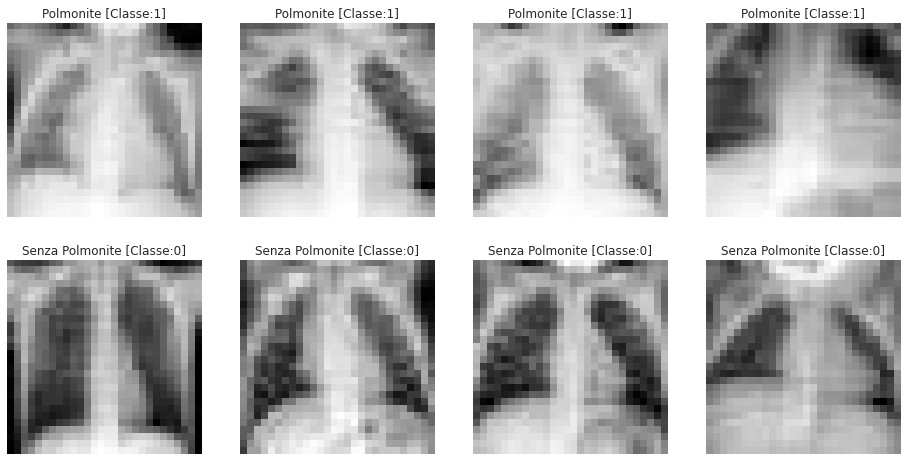

In [85]:
images = np.load("../res/pneumonia_images.npy")
labels = np.load("../res/pneumonia_labels.npy")

indices_with_pneumonia = np.where(labels == 1)[0]
indices_without_pneumonia = np.where(labels == 0)[0]

plt.figure(figsize=(16, 8))

for i in range(4):
    # Immagini con polmonite
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[indices_with_pneumonia[i]], cmap='gray')
    plt.title(f'Polmonite [Classe:{labels[indices_with_pneumonia[i]][0]}]')
    plt.axis('off')

    # Immagini senza polmonite
    plt.subplot(2, 4, i + 5)
    plt.imshow(images[indices_without_pneumonia[i]], cmap='gray')
    plt.title(f'Senza Polmonite [Classe:{labels[indices_without_pneumonia[i]][0]}]')
    plt.axis('off')

plt.show()


# Preparazione dei Dati

In questa sezione, prepareremo i dati per l'addestramento dei modelli. Le fasi principali includeranno:
- **Normalizzazione**: Ridimensionamento dei valori dei pixel in un range [0, 1].
- **Suddivisione dei Dati**: Separazione del dataset in set di training, validation e testing.


In [86]:
# Normalizzazione delle immagini (i valori dei pixel vengono ridotti a [0, 1])
images = images / 255.0

# Suddivisione del dataset in training (70%), validation (15%) e testing (15%)
images_training, X_temp, labels_training, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
images_validation, images_testing, labels_validation, labels_testing = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Flatten delle immagini per compatibilità con primi modelli
images_training_flat = images_training.reshape(images_training.shape[0], -1)
images_validation_flat = images_validation.reshape(images_validation.shape[0], -1)
images_testing_flat = images_testing.reshape(images_testing.shape[0], -1)

# Flatten delle immagini per compatibilità con lenet e le altre cnn
images_training_cnn = images_training.reshape(-1,28,28,1)
images_validation_cnn = images_validation.reshape(-1,28,28,1)
images_testing_cnn = images_testing.reshape(-1,28,28,1)

# Unione di training e validation set per training sul modello finale
images_train_val = np.concatenate((images_training, images_validation))
labels_train_val = np.concatenate((labels_training, labels_validation))
# Appiattimento del nuovo set di dati combinato
images_train_val_flat = images_train_val.reshape(images_train_val.shape[0], -1)
images_train_val_cnn = images_train_val.reshape(-1,28,28,1)

# Stampa separata delle dimensioni delle immagini
print(f"Dimensioni delle Immagini [STD]: {images_training.shape[1]}x{images_training.shape[2]}")
print(f"Dimensioni delle Immagini [FLATTENED]: {images_training_flat.shape[1]}")
print(f"Dimensioni delle Immagini [CNN]: {images_training_cnn.shape[1]}x{images_training_cnn.shape[2]}")

Dimensioni delle Immagini [STD]: 28x28
Dimensioni delle Immagini [FLATTENED]: 784
Dimensioni delle Immagini [CNN]: 28x28


In [87]:
def display_dataset_split_info(images_training, labels_training, images_validation, labels_validation, images_testing, labels_testing):
    """
    Calcola e visualizza le percentuali delle classi 0 e 1 nei set di dati di training, validation e test.
    
    Args:
        images_training: Immagini del set di training.
        labels_training: Etichette del set di training.
        images_validation: Immagini del set di validation.
        labels_validation: Etichette del set di validation.
        images_testing: Immagini del set di testing.
        labels_testing: Etichette del set di testing.
    """

    # Funzione interna per calcolare le percentuali di classi 0 e 1
    def calculate_class_percentages(labels):
        class_0_percentage = (labels == 0).mean() * 100
        class_1_percentage = (labels == 1).mean() * 100
        return class_0_percentage, class_1_percentage

    # Calcolo delle percentuali di classi nei vari set
    training_class_0, training_class_1 = calculate_class_percentages(labels_training)
    validation_class_0, validation_class_1 = calculate_class_percentages(labels_validation)
    testing_class_0, testing_class_1 = calculate_class_percentages(labels_testing)

    # Preparazione delle righe per la tabella
    rows = [
        ["Training Set", str(images_training.shape[0]), f"{training_class_0:.2f}", f"{training_class_1:.2f}"],
        ["Validation Set", str(images_validation.shape[0]), f"{validation_class_0:.2f}", f"{validation_class_1:.2f}"],
        ["Test Set", str(images_testing.shape[0]), f"{testing_class_0:.2f}", f"{testing_class_1:.2f}"],
        ["TOT", str(images_training.shape[0] + images_validation.shape[0] + images_testing.shape[0]), 
         f"{(training_class_0 + validation_class_0 + testing_class_0) / 3:.2f}", 
         f"{(training_class_1 + validation_class_1 + testing_class_1) / 3:.2f}"]
    ]

    # Definizione delle colonne della tabella
    columns = [
        {'header': 'Dataset', 'justify': 'left', 'style': 'bright_magenta'},
        {'header': 'Numero di Immagini', 'justify': 'right', 'style': 'bright_cyan'},
        {'header': 'Classe 0 (%)', 'justify': 'right', 'style': 'bright_green'},
        {'header': 'Classe 1 (%)', 'justify': 'right', 'style': 'bright_red'}
    ]

    # Creazione e visualizzazione della tabella usando l'utility
    create_rich_table("Dataset Split Information", columns, rows)

    
display_dataset_split_info(images_training, labels_training, images_validation, labels_validation, images_testing, labels_testing)


                      Dataset Split Information                      
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Dataset        ┃ Numero di Immagini ┃ Classe 0 (%) ┃ Classe 1 (%) ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Training Set   │               3662 │        25.72 │        74.28 │
│ Validation Set │                785 │        28.03 │        71.97 │
│ Test Set       │                785 │        23.82 │        76.18 │
│ TOT            │               5232 │        25.86 │        74.14 │
└────────────────┴────────────────────┴──────────────┴──────────────┘

# Implementazione dei Modelli

Ora procederemo con l'implementazione di diversi modelli di machine learning per affrontare il problema della classificazione muovendoci dai più semplici a quelli più sofisticati per poi metterli a confronto.

## Implementazione dei Modelli di base - KNearestNeighbours

In [88]:
model_name = "KNN"

# Definizione dell'intervallo di iperparametri da esplorare
param_dist = {
    'n_neighbors': np.arange(1, 31),  # Numero di vicini da usare
    'weights': ['uniform', 'distance'],  # Funzione di peso usata per la previsione
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Metrica di distanza
    'p': [1, 2, 3],  # Parametro di potenza per la metrica Minkowski
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo usato per trovare i vicini
}

# Inizializzazione del modello KNN
knn_model = KNeighborsClassifier()

# Configurazione di RandomizedSearchCV con cross-validation a 5 fold
random_search = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist,
    n_iter=30,  # Numero di configurazioni di parametri campionate
    cv=5,  # Cross-validation a 5 fold
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Esecuzione della ricerca randomizzata sui dati di training
random_search.fit(images_training_flat, labels_training.ravel())

printSuccess("KNN MODEL TRAINED SUCCESSFULLY!")

KNN MODEL TRAINED SUCCESSFULLY!

In [89]:
# Estrazione dei migliori iperparametri
best_params = random_search.best_params_

# Stampa dei migliori iperparametri in una tabella formattata
print_best_params_table(model_name, best_params)

 Best Hyperparameters for KNN 
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Hyperparameter ┃   Value   ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ weights        │ distance  │
│ p              │     2     │
│ n_neighbors    │     8     │
│ metric         │ manhattan │
│ algorithm      │ ball_tree │
└────────────────┴───────────┘

In [90]:
# Addestramento del modello con tutti i dati di addestramento (training + validation)
final_model = KNeighborsClassifier(**best_params)
final_model.fit(images_train_val_flat, labels_train_val.ravel())

# 5. Valutazione e salvataggio dei risultati sul test set
evaluate_and_save_model(model_name, final_model, images_testing_flat, labels_testing)

{'0': {'precision': 0.9491525423728814, 'recall': 0.8983957219251337, 'f1-score': 0.9230769230769231, 'support': 187.0}, '1': {'precision': 0.96875, 'recall': 0.9849498327759197, 'f1-score': 0.9767827529021559, 'support': 598.0}, 'accuracy': 0.9643312101910828, 'macro avg': {'precision': 0.9589512711864407, 'recall': 0.9416727773505267, 'f1-score': 0.9499298379895396, 'support': 785.0}, 'weighted avg': {'precision': 0.9640815610493361, 'recall': 0.9643312101910828, 'f1-score': 0.9639891348418775, 'support': 785.0}}


Model Evaluation Results for KNN 
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric               ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy             │ 0.9643 │
│ Precision (wgtd_avg) │ 0.9641 │
│ Recall (wgtd_avg)    │ 0.9643 │
│ F1-Score (wgtd_avg)  │ 0.9640 │
└──────────────────────┴────────┘

## Implementazione dei Modelli di base - Random Forest

In [91]:
model_name = "Random Forest"
# Definizione del range di iperparametri da esplorare
param_grid = {
    'n_estimators': [100, 200, 300],  # Numero di alberi nella foresta
    'max_depth': [10, 20, 30, None],  # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],  # Numero minimo di campioni richiesti per dividere un nodo
    'min_samples_leaf': [1, 2, 4],  # Numero minimo di campioni che un nodo foglia deve contenere
    'max_features': ['sqrt', 'log2'],  # Numero massimo di caratteristiche considerate per la migliore divisione
    'bootstrap': [True, False],  # Se usare o meno il bootstrap
    'criterion': ['gini', 'entropy'],  # Criterio di divisione
    'class_weight': ['balanced', None]  # Pesi delle classi
}

# Inizializzazione del modello Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurazione della Randomized Search con Cross-Validation (5-fold)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Esecuzione della Randomized Search sul set di training
random_search.fit(images_training_flat, labels_training.ravel())

printSuccess("RANDOM-FOREST MODEL TRAINED SUCCESSFULLY!")

RANDOM-FOREST MODEL TRAINED SUCCESSFULLY!

In [92]:

# Ottenimento dei migliori iperparametri trovati
best_params = random_search.best_params_

# Mostra i migliori iperparametri trovati
print_best_params_table(model_name, best_params)

Best Hyperparameters for Random 
             Forest             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Hyperparameter    ┃  Value   ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ n_estimators      │   300    │
│ min_samples_split │    2     │
│ min_samples_leaf  │    1     │
│ max_features      │   sqrt   │
│ max_depth         │    30    │
│ criterion         │ entropy  │
│ class_weight      │ balanced │
│ bootstrap         │  False   │
└───────────────────┴──────────┘

In [93]:
#  Addestramento del modello con tutti i dati di addestramento (training + validation)
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(images_train_val_flat, labels_train_val.ravel())

# 6. Valutazione e salvataggio dei risultati sul test set
evaluate_and_save_model(model_name, final_model, images_testing_flat, labels_testing)

{'0': {'precision': 0.9425287356321839, 'recall': 0.8770053475935828, 'f1-score': 0.9085872576177285, 'support': 187.0}, '1': {'precision': 0.9623567921440261, 'recall': 0.9832775919732442, 'f1-score': 0.9727047146401985, 'support': 598.0}, 'accuracy': 0.9579617834394905, 'macro avg': {'precision': 0.952442763888105, 'recall': 0.9301414697834135, 'f1-score': 0.9406459861289636, 'support': 785.0}, 'weighted avg': {'precision': 0.9576334207201861, 'recall': 0.9579617834394905, 'f1-score': 0.9574308745596865, 'support': 785.0}}


  Model Evaluation Results for   
          Random Forest          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric               ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy             │ 0.9580 │
│ Precision (wgtd_avg) │ 0.9576 │
│ Recall (wgtd_avg)    │ 0.9580 │
│ F1-Score (wgtd_avg)  │ 0.9574 │
└──────────────────────┴────────┘

## Implementazione dei Modelli di base - Regressione Logistica

In [94]:
model_name = "Logistic Regression"

# Definizione del range di iperparametri da esplorare, con filtro delle combinazioni non valide
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': uniform(0.01, 10),
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None],
    'solver': ['saga', 'liblinear', 'newton-cg', 'lbfgs', 'sag', 'newton-cholesky'], 
    'warm_start': [True, False]
}

# Inizializzazione del modello Logistic Regression
logreg_model = LogisticRegression(random_state=42)

# Configurazione di RandomizedSearchCV con cross-validation a 5 fold
random_search = RandomizedSearchCV(
    estimator=logreg_model,
    param_distributions=param_dist,  # Utilizzo diretto di param_dist
    n_iter=30,  # Numero di configurazioni di parametri campionate
    cv=5,  # Cross-validation a 5 fold
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Esecuzione della ricerca randomizzata sui dati di training
random_search.fit(images_training_flat, labels_training.ravel())

printSuccess("LOGISTIC-REGRESSION MODEL TRAINED SUCCESSFULLY!")

/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/edoman000/.local/lib/python3.10/site-packages/sklearn/linea

LOGISTIC-REGRESSION MODEL TRAINED SUCCESSFULLY!

In [95]:
# Estrazione dei migliori iperparametri
best_params = random_search.best_params_

# Stampa dei migliori iperparametri in una tabella formattata
print_best_params_table(model_name, best_params)

   Best Hyperparameters for Logistic   
              Regression               
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃       Value        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ C              │ 2.9314464853521813 │
│ class_weight   │        None        │
│ fit_intercept  │        True        │
│ penalty        │         l2         │
│ solver         │  newton-cholesky   │
│ warm_start     │        True        │
└────────────────┴────────────────────┘

In [96]:
# 5. Addestramento del modello con tutti i dati di addestramento (training + validation)
final_model = LogisticRegression(**best_params, random_state=42)
final_model.fit(images_train_val_flat, labels_train_val.ravel())

# 6. Valutazione e salvataggio dei risultati sul test set
evaluate_and_save_model(model_name, final_model, images_testing_flat, labels_testing)

{'0': {'precision': 0.949438202247191, 'recall': 0.9037433155080213, 'f1-score': 0.9260273972602739, 'support': 187.0}, '1': {'precision': 0.9703459637561779, 'recall': 0.9849498327759197, 'f1-score': 0.9775933609958506, 'support': 598.0}, 'accuracy': 0.9656050955414013, 'macro avg': {'precision': 0.9598920830016844, 'recall': 0.9443465741419705, 'f1-score': 0.9518103791280623, 'support': 785.0}, 'weighted avg': {'precision': 0.965365388721553, 'recall': 0.9656050955414013, 'f1-score': 0.9653094944754012, 'support': 785.0}}


  Model Evaluation Results for   
       Logistic Regression       
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric               ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy             │ 0.9656 │
│ Precision (wgtd_avg) │ 0.9654 │
│ Recall (wgtd_avg)    │ 0.9656 │
│ F1-Score (wgtd_avg)  │ 0.9653 │
└──────────────────────┴────────┘

## Implementazione CNN - MPL baseline

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,802 (1.01 MB)

 Trainable params: 265,802 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8209 - loss: 0.4580 - val_accuracy: 0.8497 - val_loss: 0.3696
Epoch 2/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9088 - loss: 0.2137 - val_accuracy: 0.9197 - val_loss: 0.2146
Epoch 3/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9303 - loss: 0.1715 - val_accuracy: 0.9299 - val_loss: 0.1744
Epoch 4/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.1549 - val_accuracy: 0.9338 - val_loss: 0.1657
Epoch 5/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9427 - loss: 0.1468 - val_accuracy: 0.9312 - val_loss: 0.1649
Epoch 6/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9462 - loss: 0.1387 - val_accuracy: 0.9312 - val_loss: 0.1633
Epoch 7/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9484 - loss: 0.1348 - val_accuracy: 0.9338 - val_loss: 0.1614
Epoch 8/150
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9487 - loss: 0.1305 - val_accu

MPL-BASELINE MODEL TRAINED SUCCESSFULLY!

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
{'0': {'precision': 0.9329608938547486, 'recall': 0.893048128342246, 'f1-score': 0.912568306010929, 'support': 187.0}, '1': {'precision': 0.966996699669967, 'recall': 0.979933110367893, 'f1-score': 0.973421926910299, 'support': 598.0}, 'accuracy': 0.9592356687898089, 'macro avg': {'precision': 0.9499787967623579, 'recall': 0.9364906193550695, 'f1-score': 0.9429951164606141, 'support': 785.0}, 'weighted avg': {'precision': 0.9588888070744945, 'recall': 0.9592356687898089, 'f1-score': 0.9589255866450987, 'support': 785.0}}


Model Evaluation Results for MPL 
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric               ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy             │ 0.9592 │
│ Precision (wgtd_avg) │ 0.9589 │
│ Recall (wgtd_avg)    │ 0.9592 │
│ F1-Score (wgtd_avg)  │ 0.9589 │
└──────────────────────┴────────┘

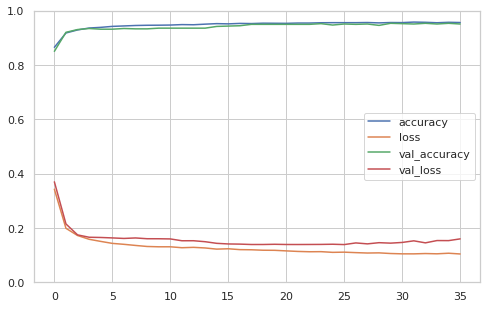

In [99]:
model_name = "MPL"

# THE ONLY PURPOSE OF THIS IS TO SET THE SEEDS AND HAVE SAME RESULTS OVER DIFFERENT RUNS
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
# THE ONLY PURPOSE OF THIS IS TO SET THE SEEDS AND HAVE SAME RESULTS OVER DIFFERENT RUNS

CNN_mpl = tf.keras.models.Sequential()
CNN_mpl.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
CNN_mpl.add(tf.keras.layers.Dense(300, activation="relu"))
CNN_mpl.add(tf.keras.layers.Dense(100, activation="relu"))
CNN_mpl.add(tf.keras.layers.Dense(2, activation="softmax"))
CNN_mpl.summary()

CNN_mpl.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history = CNN_mpl.fit(images_training_cnn, labels_training, epochs=150,
                    validation_data=(images_validation_cnn, labels_validation),
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

printSuccess("MPL-BASELINE MODEL TRAINED SUCCESSFULLY!")

# Valutazione del modello LeNet sul test set
evaluate_and_save_model_cnn(model_name, CNN_mpl, images_testing_cnn, labels_testing, history)

## Implementazione CNN - LeNet

started from LeNet-5, then used the approach sigmoid replaced with relu to have better performance


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,026 (238.38 KB)

 Trainable params: 61,026 (238.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6381 - loss: 0.6571 - val_accuracy: 0.7197 - val_loss: 0.5320
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7679 - loss: 0.4578 - val_accuracy: 0.8344 - val_loss: 0.3312
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8908 - loss: 0.2744 - val_accuracy: 0.8879 - val_loss: 0.2652
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9069 - loss: 0.2145 - val_accuracy: 0.9096 - val_loss: 0.2102
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9154 - loss: 0.1922 - val_accuracy: 0.9172 - val_loss: 0.2016
Epoch 6/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9264 - loss: 0.1735 - val_accuracy: 0.9261 - val_loss: 0.1867
Epoch 7/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9349 - loss: 0.1586 - val_accuracy: 0.9287 - val_loss: 0.1783
Epoch 8/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9410 - loss: 0.1467 - val_accuracy: 0.9287 - 

LENET MODEL TRAINED SUCCESSFULLY!

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
{'0': {'precision': 0.9521276595744681, 'recall': 0.9572192513368984, 'f1-score': 0.9546666666666667, 'support': 187.0}, '1': {'precision': 0.9865996649916248, 'recall': 0.9849498327759197, 'f1-score': 0.9857740585774059, 'support': 598.0}, 'accuracy': 0.978343949044586, 'macro avg': {'precision': 0.9693636622830464, 'recall': 0.9710845420564092, 'f1-score': 0.9702203626220363, 'support': 785.0}, 'weighted avg': {'precision': 0.9783878624272829, 'recall': 0.978343949044586, 'f1-score': 0.9783637626700068, 'support': 785.0}}


  Model Evaluation Results for   
              LeNet              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric               ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy             │ 0.9783 │
│ Precision (wgtd_avg) │ 0.9784 │
│ Recall (wgtd_avg)    │ 0.9783 │
│ F1-Score (wgtd_avg)  │ 0.9784 │
└──────────────────────┴────────┘

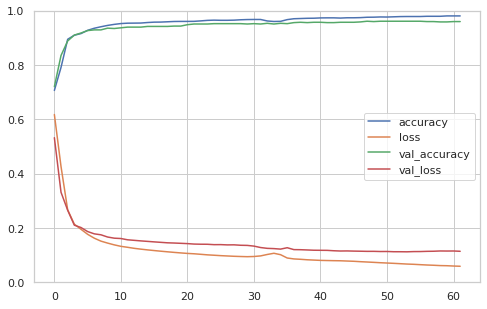

In [100]:
model_name = "LeNet"

# THE ONLY PURPOSE OF THIS IS TO SET THE SEEDS AND HAVE SAME RESULTS OVER DIFFERENT RUNS
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
conv_init = tf.keras.initializers.GlorotUniform(seed=42)
dense_init = tf.keras.initializers.GlorotUniform(seed=42)
# THE ONLY PURPOSE OF THIS IS TO SET THE SEEDS AND HAVE SAME RESULTS OVER DIFFERENT RUNS

# Definizione modello LeNet
lenet = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1), kernel_initializer=conv_init),
            tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='relu'),
            tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu', kernel_initializer=dense_init),
            tf.keras.layers.Dense(84, activation='relu', kernel_initializer=dense_init),
            tf.keras.layers.Dense(2, activation="softmax")]) 


lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

lenet.summary()

history = lenet.fit(images_training_cnn, labels_training, epochs=150,
                    validation_data=(images_validation_cnn, labels_validation), batch_size = 256,
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])

printSuccess("LENET MODEL TRAINED SUCCESSFULLY!")

# Riaddestramento del modello con il set combinato di training + validation (RISCHIO OVERFITTING)
#lenet.fit(images_train_val_cnn, labels_train_val, epochs=10, batch_size=256)

# Valutazione del modello LeNet sul test set
evaluate_and_save_model_cnn(model_name, lenet, images_testing_cnn, labels_testing, history)

## Miglioramento CNN

sperimentare con Conv2D e MaxPooling Dropout, data augmentation -> ottenere un approccio ancora migliore 

# Confronto modelli

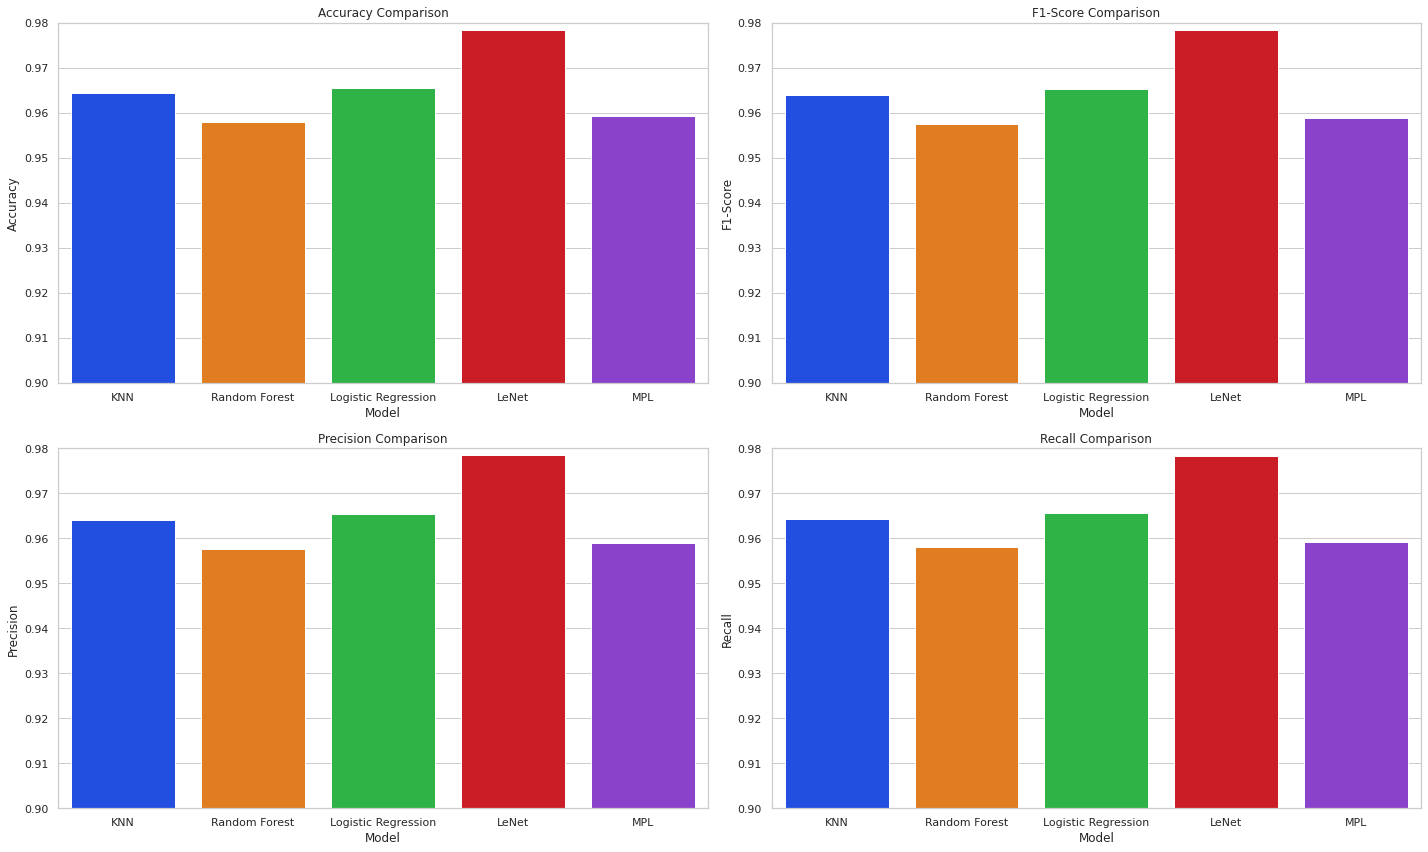

In [102]:
plot_global_comparison((0.9, 0.98))